# Kwantowe siecie neuronowe

In [1]:
import pennylane as qml
import pennylane.numpy as np

sim = 'default.qubit'

In [2]:
inputs = np.array([np.pi*0.7, np.pi/3], requires_grad=False)

weights = np.array([1.2, 0.4, 0.3] , requires_grad=True)

In [7]:
dev1 = qml.device(sim, wires=2, shots=1000)

@qml.qnode(dev1)
def vqa(inputs, weights):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.Barrier()

    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CZ(wires=[0,1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()
    return qml.probs(wires=range(2))

/Users/seba/Documents/GitHub/qml2025/venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


(<Figure size 700x300 with 1 Axes>, <Axes: >)

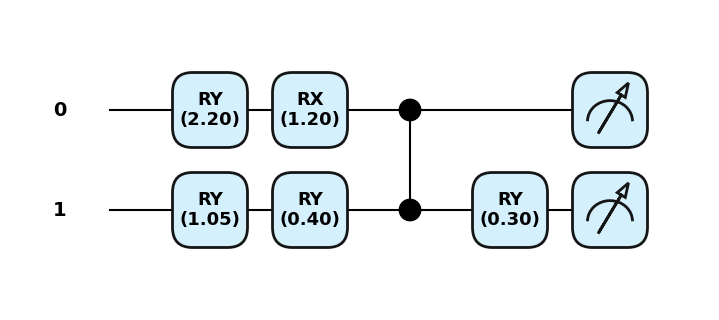

In [8]:
qml.draw_mpl(vqa, scale=0.7, style='pennylane', decimals=2, level='device')(inputs, weights)

In [12]:
vqa(inputs, weights), vqa(inputs, weights), vqa(inputs, weights)

(array([0.16 , 0.238, 0.433, 0.169]),
 array([0.173, 0.236, 0.43 , 0.161]),
 array([0.163, 0.235, 0.432, 0.17 ]))

In [11]:
qml.gradients.param_shift(vqa)(inputs, weights)

array([[ 0.115 , -0.201 , -0.1855],
       [ 0.1625,  0.1945,  0.191 ],
       [-0.1895, -0.272 ,  0.284 ],
       [-0.088 ,  0.2785, -0.2895]])

In [13]:
multi_inputs = np.stack([inputs, inputs*2, inputs, inputs*3])

In [14]:
vqa(multi_inputs, weights)

array([[0.268, 0.138, 0.233, 0.361],
       [0.02 , 0.591, 0.092, 0.297]])

In [15]:
dev1 = qml.device(sim, wires=2, shots=1000)

@qml.qnode(dev1)
def vqa2(inputs, weights):
    qml.RY(inputs[:, 0], wires=0)
    qml.RY(inputs[:, 1], wires=1)
    qml.Barrier()

    qml.RX(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CZ(wires=[0,1])
    qml.RY(weights[2], wires=1)
    qml.Barrier()
    return qml.probs(wires=range(2))


/Users/seba/Documents/GitHub/qml2025/venv/lib/python3.13/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


In [16]:
vqa2(multi_inputs, weights)

array([[0.157, 0.211, 0.439, 0.193],
       [0.011, 0.446, 0.101, 0.442],
       [0.165, 0.245, 0.426, 0.164],
       [0.073, 0.622, 0.001, 0.304]])